In [8]:
import numpy as np
import torch
import shap
from ChestWorld import ChestWorld
from dqn_agent_new import DqnAgentNew

In [9]:
# Config, load agent and env
max_steps=1_000_000

# ChestWorld
render_mode=None
size=6
agentSpawn = None
q_values=None
maxSteps=200
stepLoss=-1/maxSteps # min reward should be -1
wallCoordinates=None
randomWalls=0
chestCoordinates=None
keyCoordinates=None
randomchests=3
randomkeys=5
chestReward=1/min(randomchests, randomkeys) # max reward should be 1

# Agent
batch_size=64
lr=0.001
gamma=0.95
epsilon_start=1
epsilon_min=0.05
epsilon_decay=200_000 # 50_000 at 3000 episodes
tau=0.0005 # Was 0.005
replayBuffer=100_000

env = ChestWorld(render_mode=None, size=size, agentSpawn=agentSpawn, q_values=q_values, stepLoss=stepLoss, maxSteps=maxSteps, wallCoordinates=wallCoordinates, randomWalls=randomWalls, chestCoordinates=chestCoordinates, keyCoordinates=keyCoordinates, chestReward=chestReward, randomchests=randomchests, randomkeys=randomkeys)
observation, _ = env.reset()
agent = DqnAgentNew(env.action_space, observation,
    batch_size=batch_size,
    lr=lr,
    gamma=gamma,
    epsilon_start=epsilon_start,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay,
    tau=tau,
    replayBuffer=replayBuffer,
    wandb=False)

Action space: 4
Observation space: 6
Observation space[0]: 6
Action space: 4
Observation space: 6
Observation space[0]: 6


In [10]:
agent.replayBuffer=200_000
agent.load_model_weights(f"C:/Projects/public/XAI_NTNU/modelsToEval/CW_3chests_5keys_6x6_10000000steps.pth")
agent.inference(env=env, max_steps=200_000, epsilon=epsilon_min)

action_direction = {0: "Right",1: "Down",2: "Left", 3: "Up"}

replayBuffer = agent.replay_buffer
replayBufferStates = [replayBuffer[i][0] for i in range(len(replayBuffer))]
replayBufferStates = torch.stack(replayBufferStates)
replayBufferStates = replayBufferStates.squeeze(1)
print(f"replayBufferStates shape: {replayBufferStates.shape}")


Model loaded: C:/Projects/public/XAI_NTNU/modelsToEval/CW_3chests_5keys_6x6_10000000steps.pth
1%, time elapsed: 0 minutes and 1.07 seconds, it may finish around: 2024-11-21 13:31:15
10%, time elapsed: 0 minutes and 10.64 seconds, it may finish around: 2024-11-21 13:31:14
50%, time elapsed: 0 minutes and 54.24 seconds, it may finish around: 2024-11-21 13:31:16
99%, time elapsed: 1 minutes and 47.08 seconds, it may finish around: 2024-11-21 13:31:16
replayBufferStates shape: torch.Size([100000, 6, 6, 3])


In [11]:
model = agent.policy_net
# first 100 states
background = replayBufferStates[:20_000]
#with torch.no_grad():
print(f"Background shape: {background.shape}")

Background shape: torch.Size([20000, 6, 6, 3])


In [12]:
e = shap.DeepExplainer(model=model,
                       data=background,
                       session=None,
                       learning_phase_flags=None)

Test states shape: torch.Size([10, 6, 6, 3])
Predictions: [[0.63545036 0.57349205 0.595397   0.63885504]
 [0.6658507  0.60262644 0.62242526 0.6656766 ]
 [0.6658507  0.60262644 0.62242526 0.6656766 ]
 [0.6658507  0.60262644 0.62242526 0.6656766 ]
 [0.6658507  0.60262644 0.62242526 0.6656766 ]
 [0.6658507  0.60262644 0.62242526 0.6656766 ]
 [0.6658507  0.60262644 0.62242526 0.6656766 ]
 [0.6658507  0.60262644 0.62242526 0.6656766 ]
 [0.6658507  0.60262644 0.62242526 0.6656766 ]
 [0.6658507  0.60262644 0.62242526 0.6656766 ]]
Argmax: ['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right']
Test states type: <class 'torch.Tensor'>


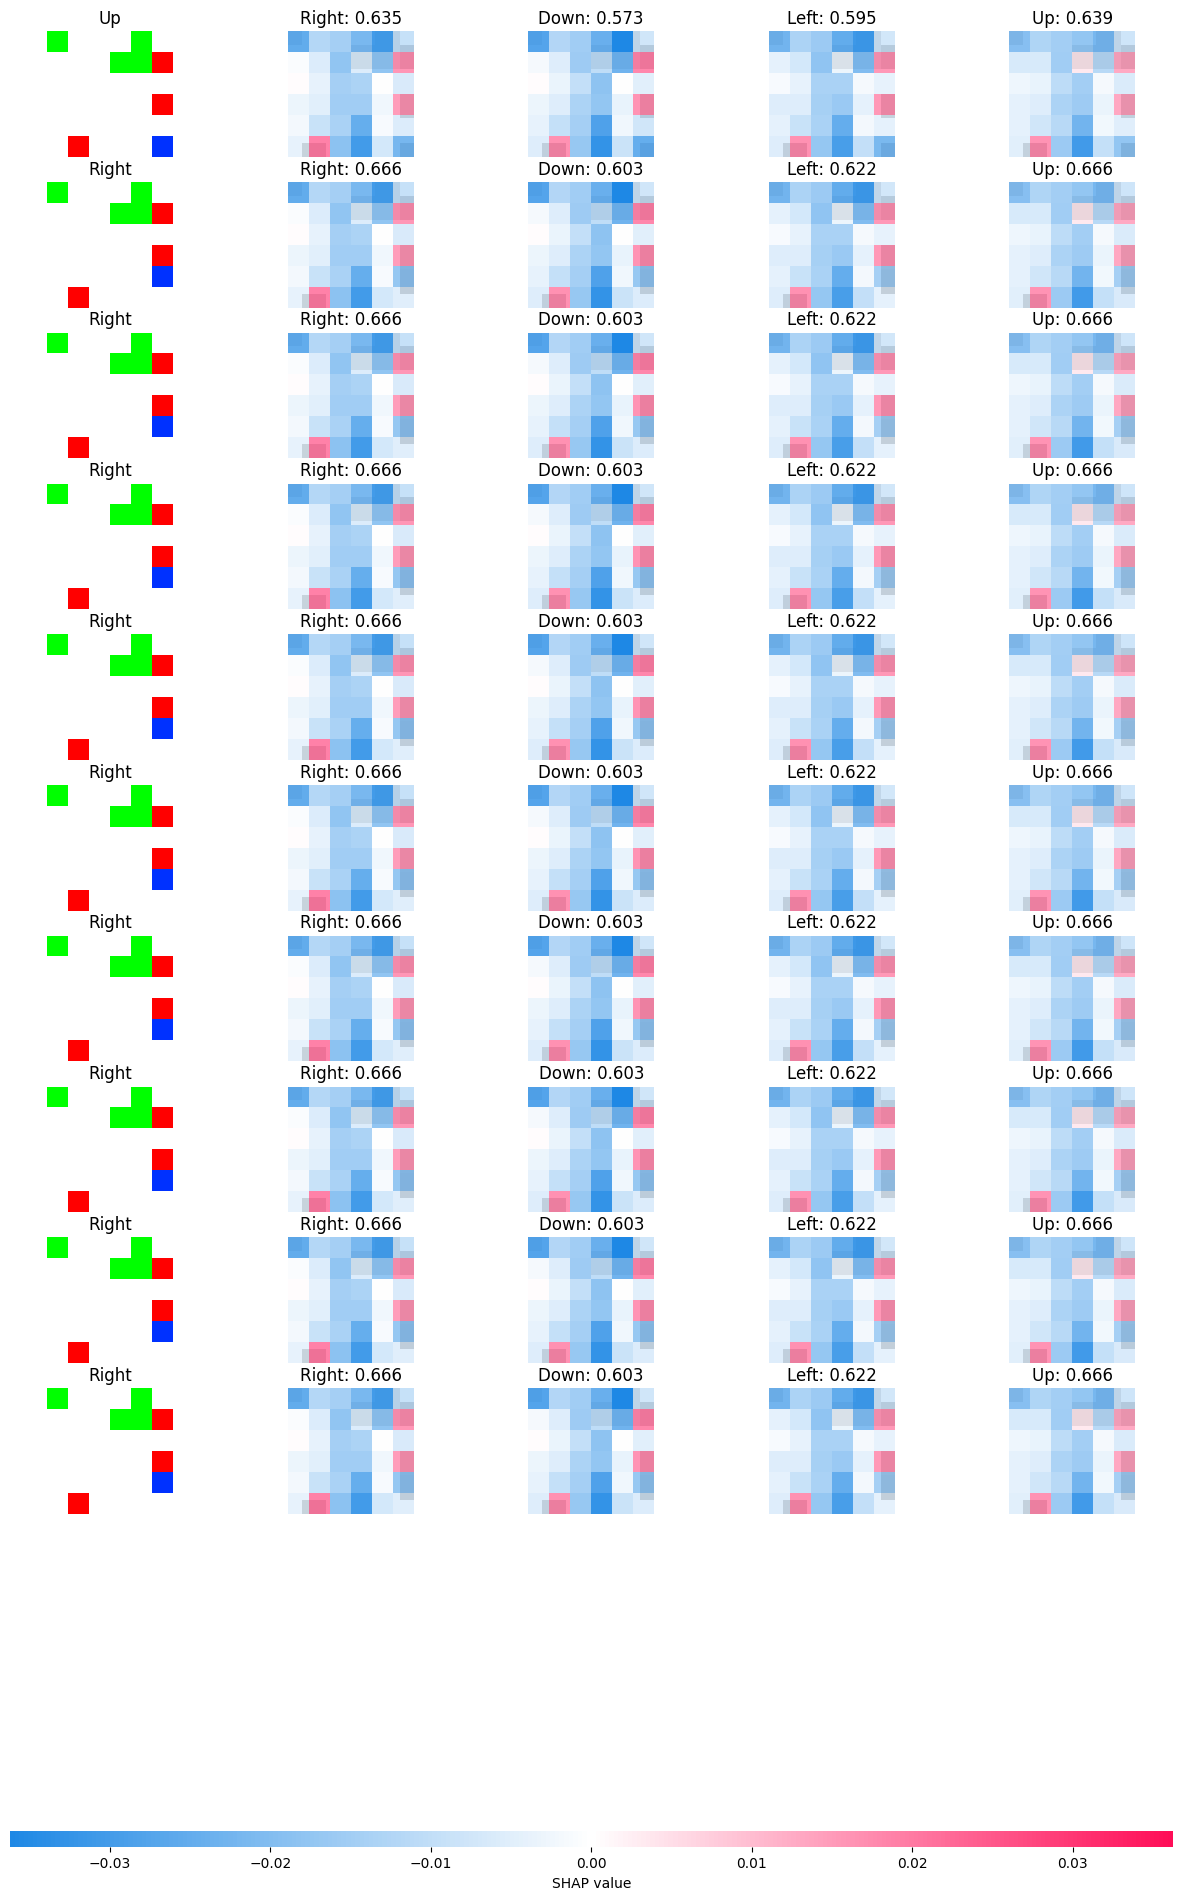

In [13]:
test_states = replayBufferStates[20_000:20_010]
print(f"Test states shape: {test_states.shape}")
with torch.no_grad():
    predictions = model(test_states).detach().numpy()
    argmax = [action_direction[np.argmax(prediction)] for prediction in predictions]
    print(f"Predictions: {predictions}")
    print(f"Argmax: {argmax}")

print(f"Test states type: {type(test_states)}")

shap_values = e.shap_values(test_states, check_additivity=False)
"""AssertionError: The SHAP explanations do not sum up to the
model's output! This is either because of a rounding error or
because an operator in your computation graph was not fully
supported. If the sum difference of %f is significant compared
to the scale of your model outputs, please post as a github issue,
with a reproducible example so we can debug it. Used framework:
    pytorch - Max. diff: 0.07974889467004687 - Tolerance: 0.01"""
# check_additivity was set to False for this reason
# this error needs to be fixed since it gives a feulty result

"""The last one was
Max. diff: 0.9542994634248316 - Tolerance: 0.01
Intolerable..."""

shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 1, 3)))
test_numpy = np.transpose(test_states.numpy(), (0, 2, 1, 3))

labels = np.array([[f"{action_direction[i]}: {predictions[j][i]:.3f}" for i in range(len(predictions[j]))] for j in range(len(predictions))])

# plot the feature attributions
shap.image_plot(shap_values=shap_numpy,
                pixel_values=test_numpy,
                labels=labels,
                true_labels=argmax,)
#                labelpad=0,
#                width=18)

In [14]:
print(f"test_states[0]: {test_states[0]}")

test_states[0]: tensor([[[0.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 0.0000, 0.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [0.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[0.0000, 1.0000, 0.0000],
         [0.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.000